## Dobór sprężarki chłodniczej na podstawie katalogu producenta

In [1]:
# get rid of error messages
import warnings;warnings.simplefilter('ignore')

# set up modules
%pylab inline
rcParams['savefig.dpi'] = 120
%config InlineBackend.figure_format = 'retina'

import CoolProp
import CoolProp.CoolProp as CP

Populating the interactive namespace from numpy and matplotlib


### Założone parametry obiegu chłodniczego
Sprężarkę dobiera się dla założonych parametrów obiegu chłodniczego/pompy ciepła:
* wydajności chłodniczej $Q_0$
* temperatury parowana $T_0$ (z uwzglednieniem ewnetualnego przegrzania $\Delta T_{sup}$)
* temperatury skraplania $T_k$

In [2]:
Q_0 = 12 * 1e3 # [kW] - wydajność grzewcza systemu chłodniczego

T_0 = 0 + 273.15 # [K] - temperatura wrzenia czynnika chłodniczego
T_k = 40 + 273.15 # [K] - temperatura skraplania czynnika chłodniczego

dT_sup = 10 # [°C] - przegrzanie

### Identyfikacja obiegu chłodniczego dla wskazanego czynnika i parametrów

Przystępując do identyfikacji w pierwszej kolejności należy wskazać czynnik chłodniczy, który docelowo ma funkcjonować w projektowanym obiegu.

In [3]:
refrigerant = "R1234yf"

Następnie wyznacza się ciśnienia pracy dla założonych temperatur parowania i skraplania oraz oblicza się wartości entalpii w punktach charakterystycznych obiegu. Znajomość entalpii pozwala obliczyć właściwe ciepło parowania, skraplania oraz właściwą pracę sprężania. 

Ciepło właściwe parowania:
$$q_0 = h_1 - h_4$$
Ciepło właściwe skraplania:
$$q_k = h_2 - h_3$$
Właściwa praca obiegu:
$$l_{ob} = h_2 - h_1$$

W następnej kolejności można obliczyć strumień masy czynnika chłodniczego, teoretyczną wydajność cieplną skraplacza oraz teoretyczną moc sprężarki.

Strumień masy czynnika chłodniczego:
$$m_0 = \frac{Q_0}{q_0}$$

Teoretyczna wydajność cieplna skraplacza:
$$Q_k = m_0 \cdot q_k$$

Teoretyczna moc sprężarki:
$$L = m_0 \cdot l_{ob}$$

In [4]:
p_0 = CP.PropsSI('P','Q',1,'T',T_0,refrigerant)
p_k = CP.PropsSI('P','Q',1,'T',T_k,refrigerant)

if dT_sup > 0: h1 = CP.PropsSI('H','P',p_0,'T',T_0+dT_sup,refrigerant)
else: h1 = CP.PropsSI('H','Q',1,'T',T_0,refrigerant)
    
s1 = CP.PropsSI('S','H',h1,'P',p_0,refrigerant)
h2 = CP.PropsSI('H','S',s1,'P',p_k,refrigerant)
h3 = CP.PropsSI('H','Q',0,'T',T_k,refrigerant)
h4 = h3

# właściwa wydajność chłodnicza, grzewcza oraz praca obiegu
q_0 = h1 - h4
q_k = h2 - h3
l_ob = h2 - h1

# strumień masy czynnika chłodniczego
m_0 = Q_0 / q_0
print ("* Strumień masy czynnika chłodniczego: %.3f [kg/s]" % m_0)

L = m_0 * l_ob
Q_k = m_0 * q_k
print ("* Wydajność parownika: %.3f [kW]" % (Q_0/1e3))
print ("* Wydajność skraplacza: %.3f [kW]" % (Q_k/1e3))
print ("* Teoretyczna moc sprężarki: %.3f [kW]" % (L/1e3))

* Strumień masy czynnika chłodniczego: 0.102 [kg/s]
* Wydajność parownika: 12.000 [kW]
* Wydajność skraplacza: 14.252 [kW]
* Teoretyczna moc sprężarki: 2.252 [kW]


### Dobór sprężarki chłodniczej dla wskazanych parametrów obiegu i czynnika referencyjnego

Z katalogu należy **dobrać sprężarkę** dla wybrany czynnika chłodniczego, określanego tutaj jako referencyjny (np. R22 lub R134a). Jest to czynnik chłodniczy, dla którego producent sprężarki przygotował charakterystykę pracy urządzenia. 

In [5]:
refrigerant_ref = "R22" # czynnik referencyjny do doboru sprężarki

Posługując się kartą katalogową, należy ustalić wartości trzech parametrów pracy urządzenia. Parametrów które zostaną następnie wykorzystane do przeliczenia wydajności ziębniczej i mocy sprężarki na wartości osiągane przy zastosowaniu docelowego czynnika. Są to:
* Pojemność skokowa [m3/h]
* Wydajność ziębnicza w założonym punkcie pracy [W]
* Rzeczywista moc sprężarki w założonym punkcie pracy [W]

Przykładowego doboru można dokonać np. na podstawie katalogu: http://www.elektronika-sa.com.pl/.

In [6]:
# pojemność/objętość skokowa
V_sp = 16.73
print ("* Teoretyczny strumień objętości pary przetłaczany przez sprężarkę: %.3f [m3/h]" % (V_sp))

# rzeczywista wydajność sprężarki
V_sp_rz_ref = 12555 # [W] - przykładowa wartość wprowadzona na podstawie katalogu
print ("* Rzeczywista wydajność ziębnicza sprężarki (z katalogu): %.3f [W]" % (V_sp_rz_ref)) 

# rzeczywista moc sprężarki
L_sp_rz_ref = 3794 # [W] -  przykładowa wartość wprowadzona na podstawie katalogu
print ("* Moc sprężarki (z katalogu): %.3f [W]" % (L_sp_rz_ref)) 

* Teoretyczny strumień objętości pary przetłaczany przez sprężarkę: 16.730 [m3/h]
* Rzeczywista wydajność ziębnicza sprężarki (z katalogu): 12555.000 [W]
* Moc sprężarki (z katalogu): 3794.000 [W]


### Obliczenia obiegu chłodniczego dla czynnika referencyjnego

Następnie należy przeprowadzić identyfikację obiegu chłodniczego dla czynnika referencyjnego (w podobny sposób jak czynnika docelowego). Jej zasadniczym celem jest ustalenie strumienia przepływu masy czynnika chłodniczego oraz objętości właściwej par czynnika na wlocie do sprężarki. Umożliwi to obliczenie właściwej objętościowej wydajności ziębienia oraz teoretycznej wydajności ziębienia, a także teoretycznej mocy ziębienia dla wybranej sprężarki (i czynnika referencyjnego).

In [7]:
# obliczenia obiegu
p_0_ref = CP.PropsSI('P','Q',1,'T',T_0,refrigerant_ref)
p_k_ref = CP.PropsSI('P','Q',1,'T',T_k,refrigerant_ref)

if dT_sup > 0: h1_ref = CP.PropsSI('H','P',p_0_ref,'T',T_0+dT_sup,refrigerant_ref)
else: h1_ref = CP.PropsSI('H','Q',1,'T',T_0,refrigerant_ref)
    
s1_ref = CP.PropsSI('S','H',h1_ref,'P',p_0_ref,refrigerant_ref)
h2_ref = CP.PropsSI('H','S',s1_ref,'P',p_k_ref,refrigerant_ref)
h3_ref = CP.PropsSI('H','Q',0,'T',T_k,refrigerant_ref)
h4_ref = h3_ref

# właściwa wydajność chłodnicza parownika i praca sprężarki
q_0_ref = h1_ref - h4_ref
l_ob_ref = h2_ref - h1_ref

# strumień masy czynnika chłodniczego dla zakładanej wydajności chłodniczej
m_0_ref = V_sp_rz_ref / q_0_ref
print ("* Strumień masy czynnika chłodniczego: %.3f [kg/s]" % m_0_ref)

# objętość właściwa par czynnika obliczanego
v1_ref = 1 / CP.PropsSI('D','H',h1_ref,'P',p_0_ref,refrigerant_ref)

# rzeczywisty strumień objętości pary przetłaczanej przez sprężarkę
V_z_ref = (m_0_ref * v1_ref) * 3600
print ("* Strumień objętości pary przetłaczany przez sprężarkę: %.3f [m3/h]" % (V_z_ref))

# właściwa objętościowa wydajność ziębienia
q_v_ref = q_0_ref / v1_ref
print ("* Właściwa objętościowa wydajność ziębienia: %.3f [J/m3]" % (q_v_ref))

V_sp_t_ref = V_sp * q_v_ref / (3600)
print ("* Teoretyczna wydajność ziębienia sprężarki: %.3f [W]" % (V_sp_t_ref))

L_ob_ref = m_0_ref * l_ob_ref
print ("* Teoretyczna moc sprężarki: %.3f [W]" % (L_ob_ref))

* Strumień masy czynnika chłodniczego: 0.077 [kg/s]
* Strumień objętości pary przetłaczany przez sprężarkę: 13.778 [m3/h]
* Właściwa objętościowa wydajność ziębienia: 3280409.589 [J/m3]
* Teoretyczna wydajność ziębienia sprężarki: 15244.792 [W]
* Teoretyczna moc sprężarki: 2278.660 [W]


### Sprawdzenie warunku sprężu
Przed przystąpieniem do dalszych obliczeń należy przyjrzeć się jaki spręż jest niezbędny do realizacji sprężania obu analizowanych czynników. W ogólnym rozumieniu stopień dostarczania sprężarki jest proporcjonalny do wartości sprężu, dlatego konieczne jest sprawdzenie dla analizowanych czynników, czy wartości sprężu znacząco od siebie nie odbiegają. Na potrzeby obliczeń projektowych powinno się przyjąć, że różnica nie przekracza kilku procent.

$$\Pi = \frac{p_0}{p_k}$$

In [8]:
print ("Stopień sprężania %s: %.3f" % (refrigerant_ref,p_k_ref/p_0_ref))
print ("Stopień sprężania %s: %.3f" % (refrigerant,p_k/p_0))
print ("Różnica: %.1f%%" % ((1-(p_k_ref/p_0_ref)/(p_k/p_0))*100))

Stopień sprężania R22: 3.080
Stopień sprężania R1234yf: 3.225
Różnica: 4.5%


### Obliczenie sprawności izentropowej $n$ oraz stopnia dostarczania $\lambda$
Teraz należy ustalić jaki jest orientacyjny stopień dostarczania wybranej przez nas sprężarki. W tym celu należy odnieść się do parametrów pracy obiegu przy zastosowaniu czynnika referencyjnego. W tym celu przeliczamy cały obieg i sprawdzamy jaka jest wydajność ziębnicza sprężarki w założonych warunkach pracy obiegu.

Na stopień dostarczania składają się wskaźniki charakterystyczne dla pracy sprężarki np.:
* wskaźnik przestrzeni szkodliwej
* wskaźnik dławienia (na tłoczeniu)
* wskaźnik podgrzania (czynnika od konstrukcji sprężarki - dodatkowe przegrzanie, zmniejsza ilość par)
* wskaźnik szczelności (praktyczne wartości: 0.96-0.98, nowoczesne konstrukcje: 0.990-0.995)

Na potrzeby przedstawionego tu doboru nie przeprowadzamy obliczeń poszczególnych wskaźników. Obliczamy jedynie stopień dostraczania porównując ze sobą parametry katalogowe podane przez producenta oraz teoretyczne wyliczone dla referencyjnego czynnika chłodniczego.

In [9]:
n_sp = L_ob_ref / L_sp_rz_ref
print ("* Współczynnik sprawności izentropowej n: %.3f [-]" % (n_sp)) 

λ_sp = V_sp_rz_ref / V_sp_t_ref
print ("* Stopień dostarczania λ: %.3f [-]" % (λ_sp))

* Współczynnik sprawności izentropowej n: 0.601 [-]
* Stopień dostarczania λ: 0.824 [-]


### Weryfikacja poprawności doboru sprężarki dla czynnika docelowego

Przyjmując założenie, że stopień dostarczania pozostaje taki sam bez względu na zastosowany czynnik (przy założeniu, że spręże dla obu czynników nie odbiegają od siebie zbytnio), można teraz obliczyć:
* strumień masy czynnika docelowego 
* wydajność ziębienia tej sprężarki przy zastosowaniu czynnika docelowego.

Jeżeli obliczona wydajność ziębienia **jest większa lub równa projektowanej**, oznacza to że sprężarka została dobrana prawidłowo.

In [10]:
# objętość właściwa par czynnika docelowego
v1 = 1 / CP.PropsSI('D','H',h1,'P',p_0,refrigerant)

# strumień masy czynnika docelowego przy założeniu, że stopień dostarczania pozostaje taki sam
# jak dla czynnika referencyjnego
m_0 = λ_sp * V_sp / (3600 * v1)
print ("* Strumień masy czynnika docelowego przetłaczany przez sprężarkę: %.3f [kg/s]" % (m_0))

Q_0_sp = m_0 * q_0
print ("* Wydajność ziębienia przy docelowym czynniku: %.3f [kW]" % (Q_0_sp/1000))

L_sp = m_0 * l_ob
print ("* Moc sprężarki (teoretyczna): %.3f [kW]" % (L_sp/1000))
print ("* Moc sprężarki (po uwzględnieniu sprawności izentropowej): %.3f [W]" % (L_sp/n_sp))
print ("* Moc sprężarki podana przez producenta: %.3f [W]" % (L_sp_rz_ref))

# Sprawdzenie warunku czy moc podana przez producenta jest większa niż moc 
# wyliczona dla nowego czynnika po uwzględnieniu sprawności izentropowej.
# Jak ten warunek nie jest spełniony to urządzenie ma za słaby silnik, aby
# prawidłowo działać z nowym czynnikiem.

if (L_sp/n_sp) < L_sp_rz_ref:
    print ("\nDOBRZE! Sprężarka wygląda na dobraną prawidłowo!")
else:
    print ("\nŻLE! Sprężarka dobrana nieprawidłowo!")

* Strumień masy czynnika docelowego przetłaczany przez sprężarkę: 0.064 [kg/s]
* Wydajność ziębienia przy docelowym czynniku: 7.554 [kW]
* Moc sprężarki (teoretyczna): 1.417 [kW]
* Moc sprężarki (po uwzględnieniu sprawności izentropowej): 2360.087 [W]
* Moc sprężarki podana przez producenta: 3794.000 [W]

DOBRZE! Sprężarka wygląda na dobraną prawidłowo!


### Wizualizacja obiegów na wykresie $\mathrm{log}\,p-h$

W pierwszej kolejności należy obliczyć wartość entalpii na końcu procesu sprężania celem uwzględnienia sprawności izentropowej $n$.

$$h_{2^\prime} = h_1 + \frac{h_2 - h_1}{n}$$

In [11]:
# korekta położenia punktu 2 na wykresie na podstawie sprawności izentropowej sprężarki
h2b = h1 + (h2 - h1) / n_sp
h2b_ref = h1_ref + (h2_ref - h1_ref) / n_sp

Wyznaczenie linii nasycenia cieczy i pary obu czynników.

In [12]:
steps = 60
pres = ones(steps)
satl = zeros(steps)
satv = zeros(steps)
pres_ref = ones(steps)
satl_ref = zeros(steps)
satv_ref = zeros(steps)

p_min = p_0 - 50000
p_crit = CP.PropsSI(refrigerant,'pcrit')
p_step = (p_crit - p_min)/(steps-1)

for i in range(0,steps):
    pres[i] = p_min + i * p_step
    satl[i] = CP.PropsSI('H','Q',0,'P',pres[i],refrigerant)
    satv[i] = CP.PropsSI('H','Q',1,'P',pres[i],refrigerant)

print ("* Ciśnienie krytyczne %s: %.0f [Pa]" % (refrigerant, p_crit))

p_min_ref = p_0 - 50000
p_crit_ref = CP.PropsSI(refrigerant_ref,'pcrit')
p_step_ref = (p_crit_ref - p_min_ref)/(steps-1)

for i in range(0,steps):
    pres_ref[i] = p_min_ref + i * p_step_ref
    satl_ref[i] = CP.PropsSI('H','Q',0,'P',pres_ref[i],refrigerant_ref)
    satv_ref[i] = CP.PropsSI('H','Q',1,'P',pres_ref[i],refrigerant_ref)

print ("* Ciśnienie krytyczne %s: %.0f [Pa]" % (refrigerant_ref, p_crit_ref))

* Ciśnienie krytyczne R1234yf: 3382200 [Pa]
* Ciśnienie krytyczne R22: 4990000 [Pa]


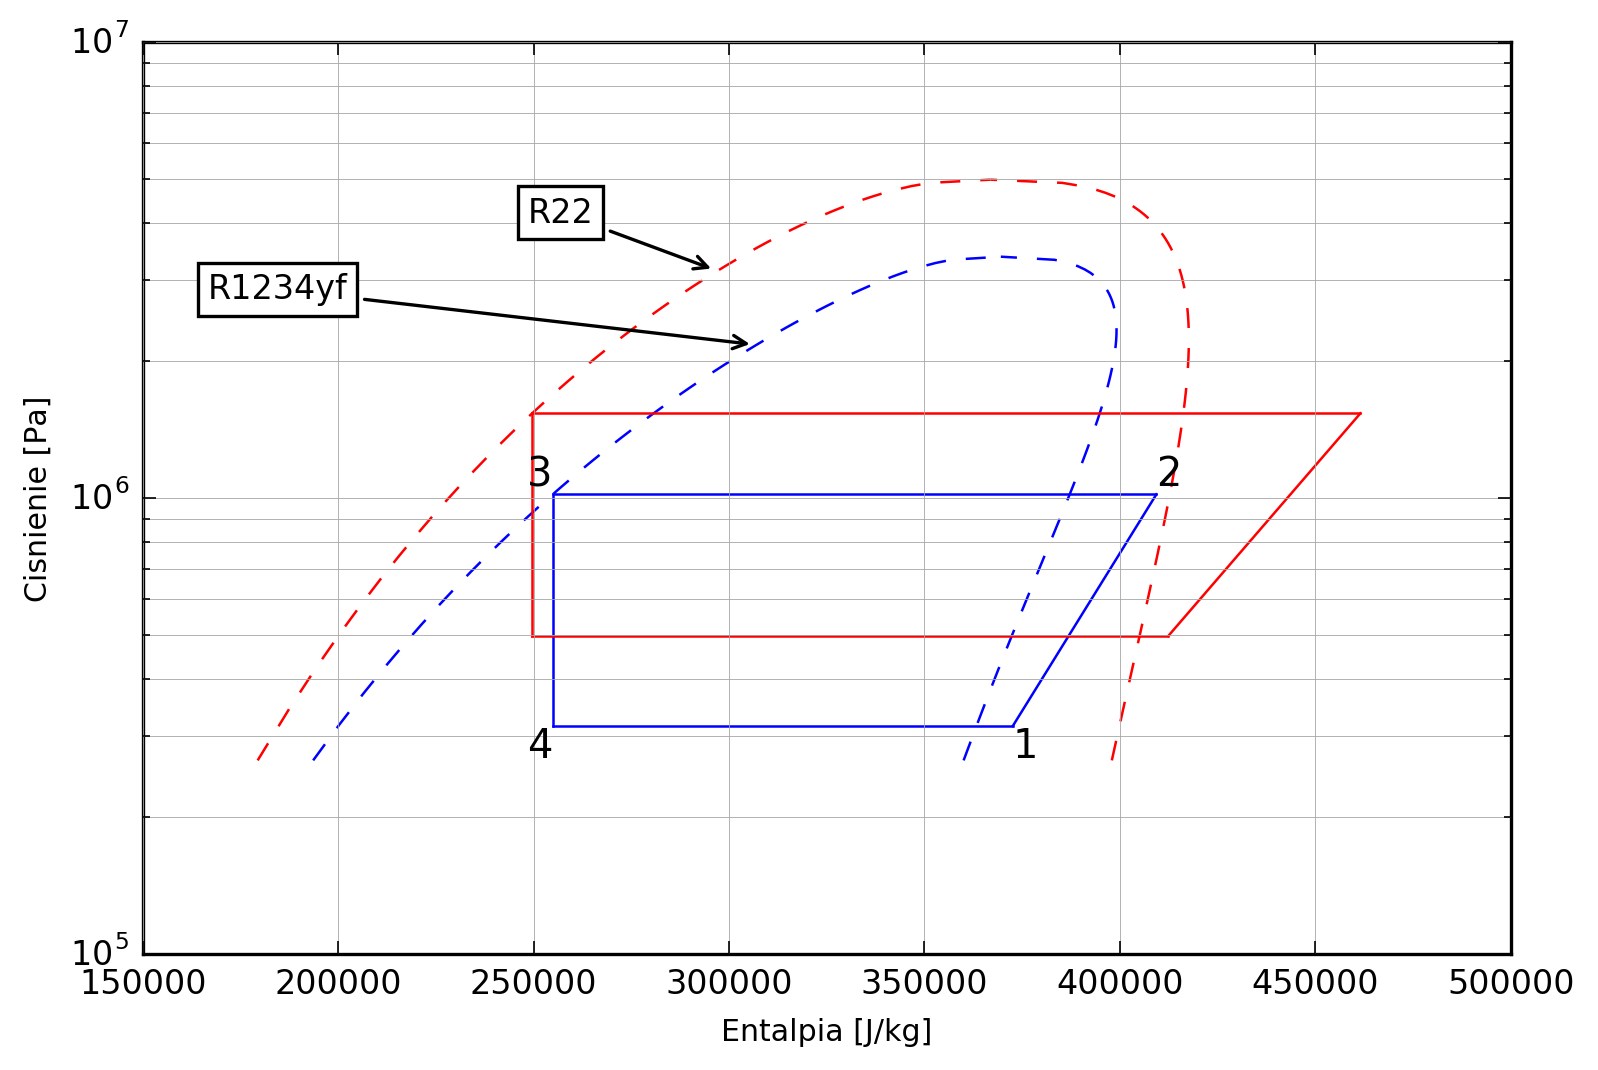

In [13]:
# plot results
plt.figure()

# grid and axes
plt.axes([0.025, 0.025, 0.95, 0.95])
plt.grid(which='major', axis='x', linewidth=0.25, linestyle='-', color='0.65')
plt.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.65')
plt.grid(which='major', axis='y', linewidth=0.25, linestyle='-', color='0.65')
plt.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.65')

# data
plt.plot([h4,h1], [p_0,p_0], 'b-', linewidth=0.75)
plt.plot([h1,h2b], [p_0,p_k], 'b-', linewidth=0.75)
plt.plot([h2b,h3], [p_k,p_k], 'b-', linewidth=0.75)
plt.plot([h3,h4], [p_k,p_0], 'b-', linewidth=0.75)

plt.semilogy(satl, pres, 'b--', linewidth=0.75)
plt.semilogy(satv, pres, 'b--', linewidth=0.75)

# data (ref)
plt.plot([h4_ref,h1_ref], [p_0_ref,p_0_ref], 'r-', linewidth=0.75)
plt.plot([h1_ref,h2b_ref], [p_0_ref,p_k_ref], 'r-', linewidth=0.75)
plt.plot([h2b_ref,h3_ref], [p_k_ref,p_k_ref], 'r-', linewidth=0.75)
plt.plot([h3_ref,h4_ref], [p_k_ref,p_0_ref], 'r-', linewidth=0.75)

plt.semilogy(satl_ref, pres_ref, 'r--', linewidth=0.75)
plt.semilogy(satv_ref, pres_ref, 'r--', linewidth=0.75)


# opis punktów
plt.text(h1, p_0, "1", fontsize=12, horizontalalignment='left', verticalalignment='top')
plt.text(h2b, p_k, "2", fontsize=12, horizontalalignment='left', verticalalignment='bottom')
plt.text(h3, p_k, "3", fontsize=12, horizontalalignment='right', verticalalignment='bottom')
plt.text(h4, p_0, "4", fontsize=12, horizontalalignment='right', verticalalignment='top')

plt.annotate(refrigerant, 
             xy=(satl[round(0.6 * steps)],pres[round(0.6 * steps)]), xytext=(satl[round(0.9 * steps)]-160000,pres[round(0.9 * steps)]), bbox=dict(boxstyle="square", fc="w"),
             arrowprops=dict(facecolor='red', arrowstyle="->"), horizontalalignment='center', 
             verticalalignment='top', fontsize=10)
plt.annotate(refrigerant_ref, 
             xy=(satl_ref[round(0.6 * steps)],pres_ref[round(0.6 * steps)]), xytext=(satl_ref[round(0.9 * steps)]-80000,pres_ref[round(0.9 * steps)]), bbox=dict(boxstyle="square", fc="w"),
             arrowprops=dict(facecolor='red', arrowstyle="->"), horizontalalignment='center', 
             verticalalignment='top', fontsize=10)

plt.xlabel('Entalpia [J/kg]',fontsize=9)
plt.ylabel('Cisnienie [Pa]',fontsize=9)